# Price stock difference tests

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
DATA_PATH = './data'

In [3]:
FILE = DATA_PATH + '/AAPL.txt'

dataset = pd.read_csv(FILE, ' ')

df = dataset.copy()

df.head()

,Date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume,AAPL.Adjusted
1,2007-01-03,3.081786,3.092143,2.925000,2.992857,1.238320e+09,2.581791
2,2007-01-04,3.001786,3.069643,2.993572,3.059286,8.472604e+08,2.639096
3,2007-01-05,3.063214,3.078571,3.014286,3.037500,8.347416e+08,2.620302
4,2007-01-08,3.070000,3.090357,3.045714,3.052500,7.971068e+08,2.633242
5,2007-01-09,3.087500,3.320714,3.041071,3.306072,3.349298e+09,2.851985


In [4]:
columns = ['Date', 'AAPL.Close']

df = df.loc[:, columns]

columns = [col.replace('.','_') for col in columns]
df.columns = columns

print(len(df))
df.head()

3525


,Date,AAPL_Close
1,2007-01-03,2.992857
2,2007-01-04,3.059286
3,2007-01-05,3.037500
4,2007-01-08,3.052500
5,2007-01-09,3.306072


In [5]:
df.isna().any()

Date          False
AAPL_Close    False
dtype: bool

### Plot the closing price

In [6]:
import datetime
import matplotlib.dates as mdates



def plot_with_dates(dates, y_values):
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in df.Date]
    ax = plt.gca()
    ax.set(title='AAPL Stock Closing Price over time', ylabel='Closing price (USD)', xlabel='Time')

    formatter = mdates.DateFormatter("%m-%Y")

    ax.xaxis.set_major_formatter(formatter)

    plt.plot(x_values, y_values)

#plot_with_dates(df.Date, df[columns[1]])

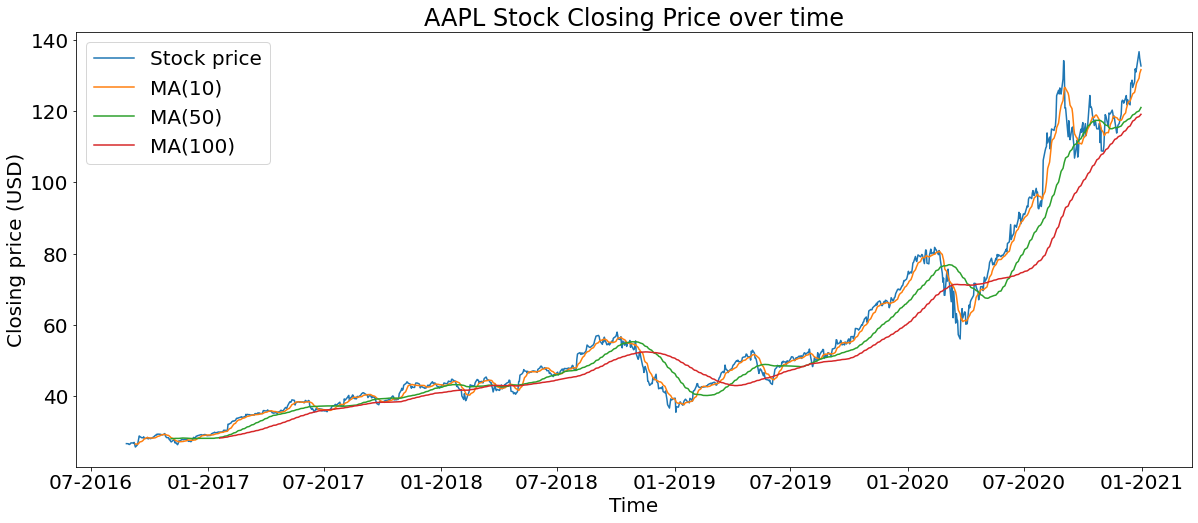

In [7]:
values = df.tail(365*3)['AAPL_Close']

x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in df.tail(365*3).Date]
ax = plt.gca()
ax.set(title='AAPL Stock Closing Price over time', ylabel='Closing price (USD)', xlabel='Time')

formatter = mdates.DateFormatter("%m-%Y")

ax.xaxis.set_major_formatter(formatter)

MAs = [10, 50, 100]

plt.plot(x_values, values, label="Stock price")

for val in MAs:
    plt.plot(x_values, values.rolling(val).mean(), label=f"MA({val})")

plt.legend(loc='best')

### Compute the daily stock difference

In [8]:
from itertools import tee

# https://docs.python.org/3/library/itertools.html#itertools-recipes
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

df.head()

values = df['AAPL_Close']

print(values[:10])

differences = list(map(lambda pair: pair[1]-pair[0], pairwise(values)))
differences.insert(0, 0)

df['Difference'] = differences

df.head()

1     2.992857
2     3.059286
3     3.037500
4     3.052500
5     3.306072
6     3.464286
7     3.421429
8     3.379286
9     3.467857
10    3.391071
Name: AAPL_Close, dtype: float64


,Date,AAPL_Close,Difference
1,2007-01-03,2.992857,0.000000
2,2007-01-04,3.059286,0.066429
3,2007-01-05,3.037500,-0.021786
4,2007-01-08,3.052500,0.015000
5,2007-01-09,3.306072,0.253572


### Outliers removal

In [9]:
from scipy import stats 
import numpy as np 

STD_THRESH = 3

def filter_zscore(serie, thresh=3):
    z = np.abs(stats.zscore(serie)) 
    filtered = (z < 3)
    return serie[filtered]

In [10]:
def label_density_hist(ax, n, bins, x=4, y=0.01, r=0, **kwargs):
    """
    adapted from https://stackoverflow.com/questions/6352740/matplotlib-label-each-bin
    """
    
    total = sum(n)

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = (bins[i + 1] - bins[i]) / x + bins[i]
        y_pos = n[i] + (n[i] * y)
        
        if n[i] < 10:
            continue
        
        label = f"{(n[i] * 100.0 / total):.1f}%"
        ax.text(x_pos, y_pos, label, kwargs)

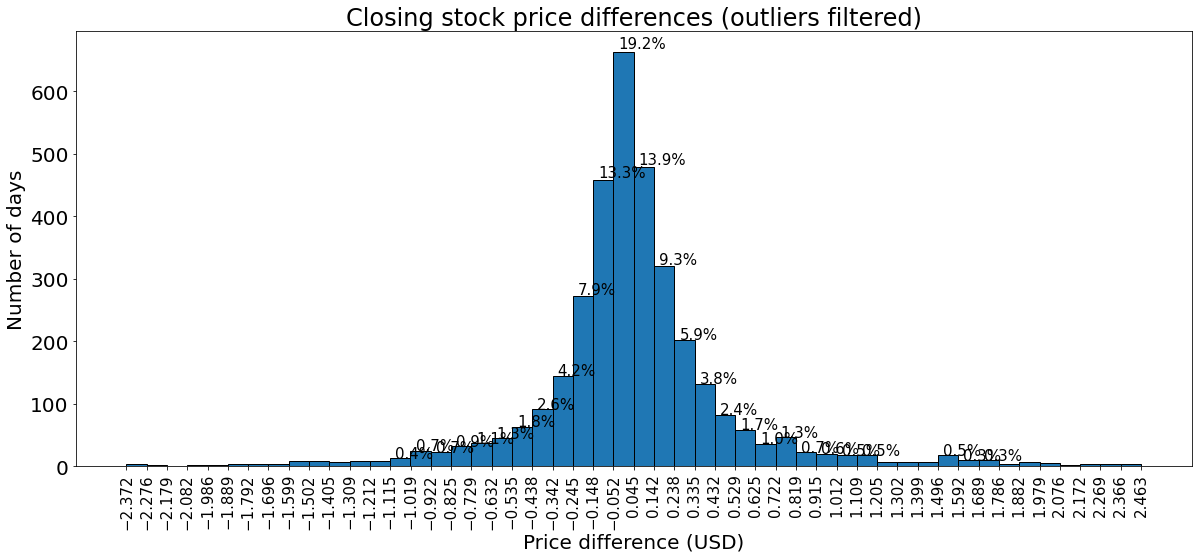

In [11]:
values = filter_zscore(df['Difference'], thresh=STD_THRESH)
ax = plt.gca()

counts, bins, patches = ax.hist(values, 50, histtype='bar', ec='black')
plt.xticks(bins, fontsize=15, rotation=90)
plt.title("Closing stock price differences (outliers filtered)")
plt.xlabel('Price difference (USD)')
plt.ylabel('Number of days')
label_density_hist(ax, counts, bins, fontsize=15)
plt.show()

[higher] : 1528 (43.3%)
[lower] : 1314 (37.3%)
[stay] : 682 (19.3%)


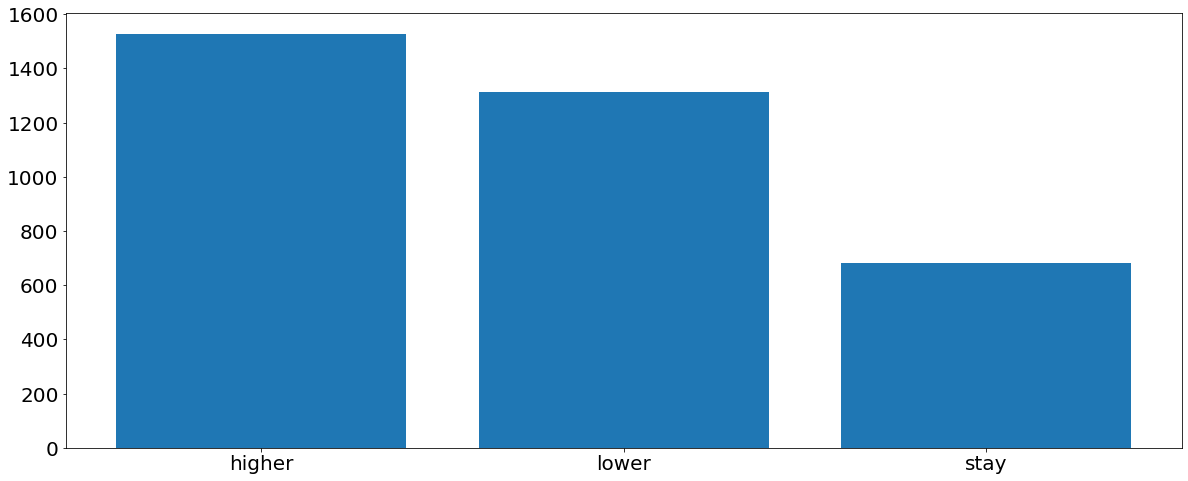

Sum of difference for still price : -0.022


In [18]:
THRESH_DIFF = 0.05

df['Tendency'] = pd.cut(x=df['Difference'], bins=[min(df['Difference']), 0-THRESH_DIFF, 0+THRESH_DIFF, max(df['Difference'])],
                labels=['lower', 'stay', 'higher'])

value_counts = df.Tendency.value_counts().to_dict()


for value, count in value_counts.items():
    print(f"[{value}] : {count} ({count * 100.0 / len(df['Tendency']):.1f}%)")
    
plt.bar(range(len(value_counts.keys())), list(value_counts.values()), align='center')
plt.xticks(range(len(value_counts.keys())), list(value_counts.keys()))

plt.show()

df_stay = df[df.Tendency == 'stay']

print(f"Sum of difference for still price : {df_stay.Difference.sum():.3f}")

### Random walk model

In [13]:
import random

random.seed(42)

# create the walk and price changes sequence
price_walk = []
for direction, count in value_counts.items():
    # filter the dataset by the current direction chosen
    df_filtered_direction = df[df.Tendency == direction]
    
    # pick at random some prices according to the current price direction chosen
    price_diffs = np.random.choice(df_filtered_direction['Difference'], size=count, replace=True)
    
    price_walk.extend([(direction, diff) for diff in price_diffs])
    
random.shuffle(price_walk)

print(price_walk[:10])

[('higher', 0.021069999999998146), ('lower', -0.4975019999999972), ('lower', -0.513573000000001), ('higher', 0.3675009999999972), ('lower', -0.1725009999999969), ('higher', 0.03571400000000047), ('higher', 1.6575009999999963), ('higher', 0.8399999999999963), ('higher', 0.0403570000000002), ('lower', -1.9174999999999969)]


In [14]:
import tqdm

prices = [df['AAPL_Close'].values[0]]

for direction, diff in price_walk: 
    prices.append(prices[-1] + diff)
    
print(len(prices))

3525


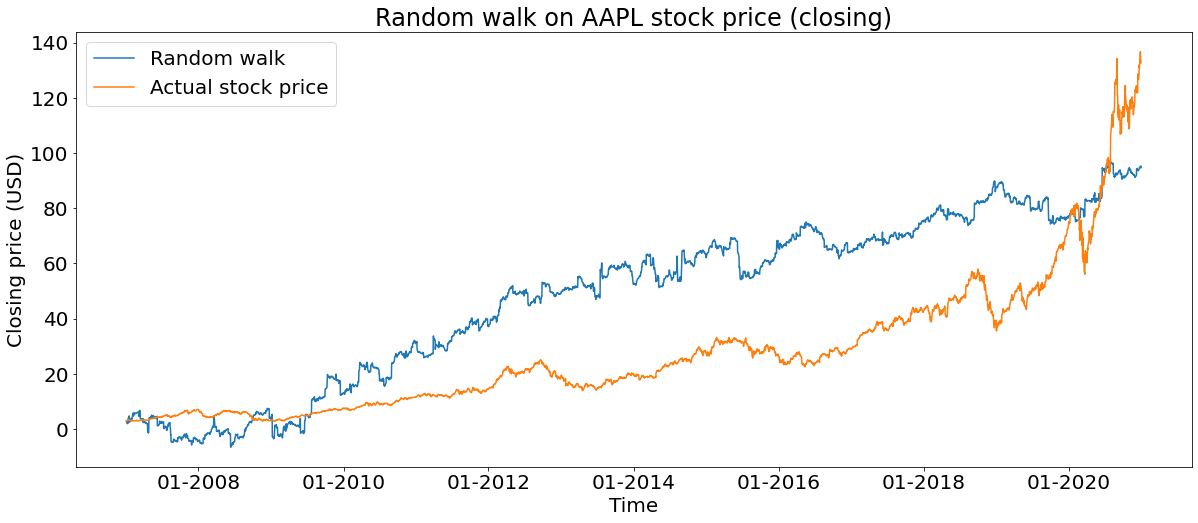

In [15]:
x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in df.Date]
ax = plt.gca()
ax.set(title='Random walk on AAPL stock price (closing)', ylabel='Closing price (USD)', xlabel='Time')

formatter = mdates.DateFormatter("%m-%Y")

ax.xaxis.set_major_formatter(formatter)
plt.plot(x_values, prices, label="Random walk")
plt.plot(x_values, df['AAPL_Close'], label="Actual stock price")


plt.legend(loc='best')

In [19]:
from sklearn.metrics import mean_squared_error

print(f"MSE : {mean_squared_error(prices, df['AAPL_Close']):.2f}")
# + correlation

MSE : 741.85


### Random walk (direction only)

In [17]:
from collections import Counter

actual_directions = df.Tendency
# sample randomly the directions
random_directions = actual_directions.sample(frac=1).reset_index()


# could do better with pandas and sklearn didnt find how yet
acc_count = 0
for random_val, actual in zip(random_directions.Tendency, actual_directions.values):
    #print(f"Random : {random_val}, actual : {actual}")
    if random_val == actual:
        acc_count += 1
        
accuracy = acc_count / float(len(actual_directions))

print(f"Accuracy score : {accuracy*100:.1f}%")

Accuracy score : 44.6%
